#Step 1: Importing libraries
###Connects to Google Drive.
###Downloads the "70 Dog Breeds Image Dataset" from Kaggle.

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import kagglehub
from google.colab import drive
import os

drive.mount('/content/drive')


# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)

Mounted at /content/drive


100%|██████████| 215M/215M [00:02<00:00, 80.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


#Step 2: Data Preprocessing and Loading

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Paths to the training and testing dataset directories
train_path = "/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train"
test_path = "/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test"

# Define transformations for the training dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Randomly crop image to 128x128 with scaling
    transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    transforms.RandomRotation(10),  # Random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random adjustments to brightness and contrast
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1] range
])

# Define transformations for the test dataset (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1] range
])

# Load the training dataset with transformations
train_data = datasets.ImageFolder(root=train_path, transform=train_transform)

# Load the test dataset with transformations
test_data  = datasets.ImageFolder(root=test_path,  transform=test_transform)

# Create DataLoader for training dataset (shuffle for randomness)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Create DataLoader for test dataset (no shuffle to maintain order)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

# Get the number of classes (breeds) in the dataset
num_classes = len(train_data.classes)

# Print class names and total number of classes
print("Classes (breeds):", train_data.classes)
print(f"Total classes: {num_classes}")


Classes (breeds): ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']
Total classes: 70


#Step 3: Dataset Summary
###Prints the number of images in the training and test datasets.

In [ ]:
print("Train samples", len(train_data))
print("Test samples", len(test_data))



Train samples 7946
Test samples 700


#Step 4: Visualizing Sample Images
###Defines a function to unnormalize and display sample images from the dataset.
###Retrieves and displays five random images with their class labels.

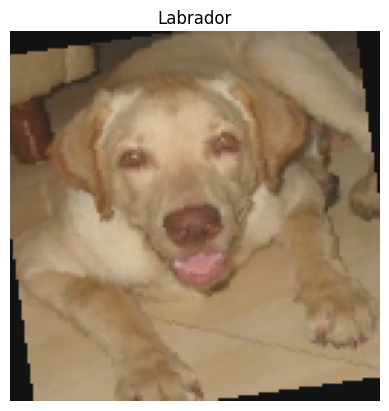

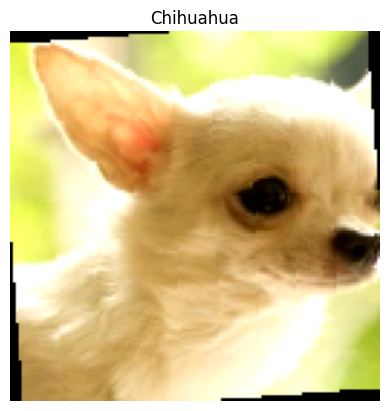

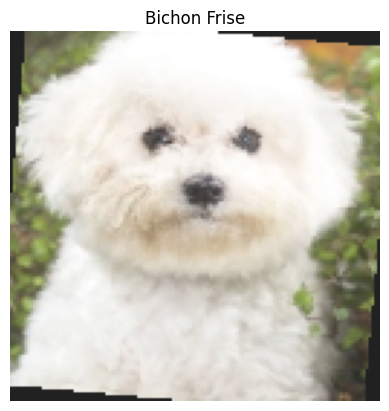

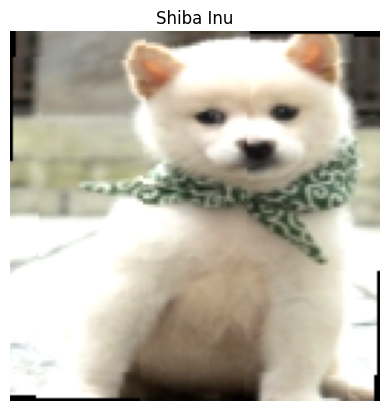

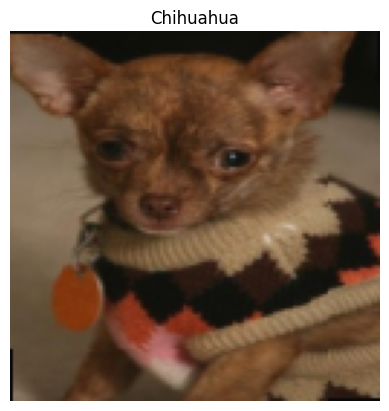

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert tensor to NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Rearrange dimensions for correct display
    plt.title(title)  # Set title with class name
    plt.axis("off")  # Hide axis for better visualization
    plt.show()

# Get a batch of training data from the DataLoader
images, labels = next(iter(train_loader))

# Display a few images with their corresponding labels
for i in range(5):  # Show 5 images
    imshow(images[i], title=train_data.classes[labels[i]])


#Step 5: Defining the CNN Model
Implements a convolutional neural network (CNN) for dog breed classification.
The network includes four convolutional blocks with batch normalization, ReLU activation, and max pooling.
Uses adaptive average pooling followed by fully connected layers for classification.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the DogCNN model for dog breed classification
class DogCNN(nn.Module):
    def __init__(self, num_classes=70):
        super(DogCNN, self).__init__()

        # First convolutional block
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces resolution by half
        )

        # Second convolutional block
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces resolution by half
        )

        # Third convolutional block
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces resolution by half
        )

        # Fourth convolutional block
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces resolution by half
        )

        # Global Average Pooling (GAP) layer
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected classification head
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout to reduce overfitting
            nn.Linear(512, 256),  # Fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Additional dropout layer
            nn.Linear(256, num_classes)  # Output layer with 'num_classes' neurons
        )

    # Define forward pass
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.gap(x)  # Apply Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        x = self.classifier(x)  # Pass through the classifier
        return x

# Function to instantiate the DogCNN model with the specified number of classes
def get_dog_cnn(num_classes=70):
    return DogCNN(num_classes=num_classes)


#Step 6: Model Initialization and Optimizer Setup
###Moves the model to GPU if available.
###Defines the loss function (CrossEntropyLoss).
###Uses Adam optimizer for training.
###Defines a function to evaluate model accuracy on the test dataset.
###Trains the model for 102 epochs.
###Uses a learning rate scheduler to adjust the learning rate dynamically.
###Saves the model with the best test accuracy to Google Drive.

In [ ]:
# Lists to store training and testing metrics
train_losses = []       # Store training loss per epoch
test_losses = []        # Store test loss per epoch
train_accuracies = []   # Store training accuracy per epoch
test_accuracies = []    # Store test accuracy per epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader


# Function to evaluate the model on a given dataset (test or validation)
def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100.0 * correct / total  # Return accuracy percentage

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = DogCNN(num_classes=70).to(device)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

# Variable to track the best model accuracy
best_test_acc = 0.0
save_path = "/content/drive/MyDrive/OurCNN-Model.pth"

num_epochs = 110  # Total number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
    train_acc = 100.0 * correct / total  # Training accuracy

    # Evaluate the model on the test set
    test_acc = evaluate_model(model, test_loader)

    # 🔹 Store loss and accuracy for visualization
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    test_losses.append(loss.item())  # Save test loss
    test_accuracies.append(test_acc)

    # Update the learning rate scheduler based on test accuracy
    scheduler.step(test_acc)

    # Save the best model based on test accuracy
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), save_path)
        print(f"The best model was saved with Test Accuracy: {test_acc:.2f}%")

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Train Accuracy: {train_acc:.2f}% | "
          f"Test Accuracy: {test_acc:.2f}%")

print(f"Best model saved at: {save_path}")


The best model was saved with Test Accuracy: 4.71%
Epoch [1/110] | Train Loss: 4.0906 | Train Accuracy: 3.54% | Test Accuracy: 4.71%
The best model was saved with Test Accuracy: 5.57%
Epoch [2/110] | Train Loss: 3.8945 | Train Accuracy: 5.26% | Test Accuracy: 5.57%
Epoch [3/110] | Train Loss: 3.8245 | Train Accuracy: 6.61% | Test Accuracy: 4.57%
The best model was saved with Test Accuracy: 6.43%
Epoch [4/110] | Train Loss: 3.7454 | Train Accuracy: 7.74% | Test Accuracy: 6.43%
The best model was saved with Test Accuracy: 8.57%
Epoch [5/110] | Train Loss: 3.6763 | Train Accuracy: 9.21% | Test Accuracy: 8.57%
The best model was saved with Test Accuracy: 11.71%
Epoch [6/110] | Train Loss: 3.5700 | Train Accuracy: 10.51% | Test Accuracy: 11.71%
The best model was saved with Test Accuracy: 16.14%
Epoch [7/110] | Train Loss: 3.4837 | Train Accuracy: 12.06% | Test Accuracy: 16.14%
Epoch [8/110] | Train Loss: 3.3906 | Train Accuracy: 13.43% | Test Accuracy: 12.57%
Epoch [9/110] | Train Loss: 3.

#step 8: Displaying graphs of accuracy and loss

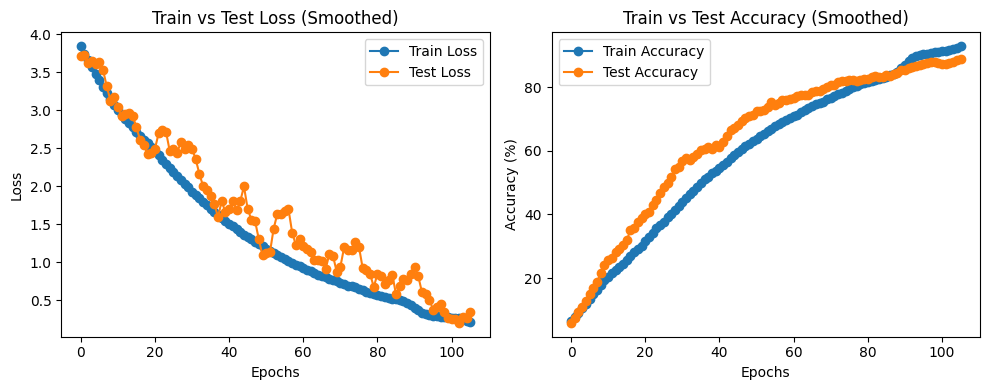

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute a moving average (smoothing)
def smooth_curve(data, window_size=5):
    if len(data) < window_size:
        return data  # Return original data if not enough points
    kernel = np.ones(window_size) / window_size  # Create a smoothing kernel
    return np.convolve(data, kernel, mode='valid')  # Apply convolution for smoothing

# Apply smoothing to loss and accuracy data
smoothed_train_losses = smooth_curve(train_losses, window_size=5)
smoothed_test_losses = smooth_curve(test_losses, window_size=5)
smoothed_train_accuracies = smooth_curve(train_accuracies, window_size=5)
smoothed_test_accuracies = smooth_curve(test_accuracies, window_size=5)

# 📊 Plot loss and accuracy graphs
plt.figure(figsize=(10, 4))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(smoothed_train_losses, label="Train Loss", marker='o')
plt.plot(smoothed_test_losses, label="Test Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss (Smoothed)")
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(smoothed_train_accuracies, label="Train Accuracy", marker='o')
plt.plot(smoothed_test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy (Smoothed)")
plt.legend()

plt.tight_layout()
plt.show()


#Step 9: Confusion Matrix Creation

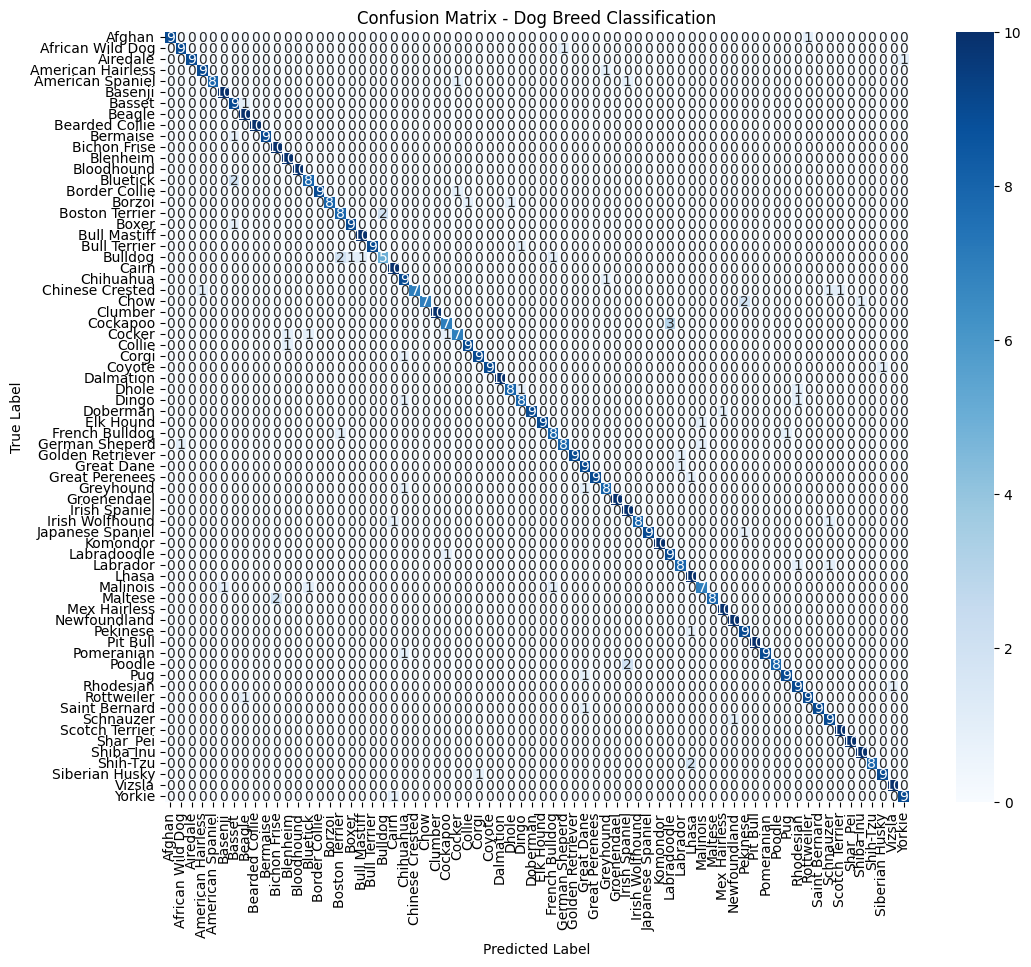

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Function to compute the confusion matrix
def compute_confusion_matrix(model, loader, classes):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            y_true.extend(labels.cpu().numpy())  # Store true labels
            y_pred.extend(predicted.cpu().numpy())  # Store predicted labels

    cm = confusion_matrix(y_true, y_pred)  # Compute the confusion matrix
    return cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Compute and display the confusion matrix
cm = compute_confusion_matrix(model, test_loader, train_data.classes)
plot_confusion_matrix(cm, train_data.classes, title="Confusion Matrix - Dog Breed Classification")



#Step 10: Visualizing Filters from the First Convolutional Layers

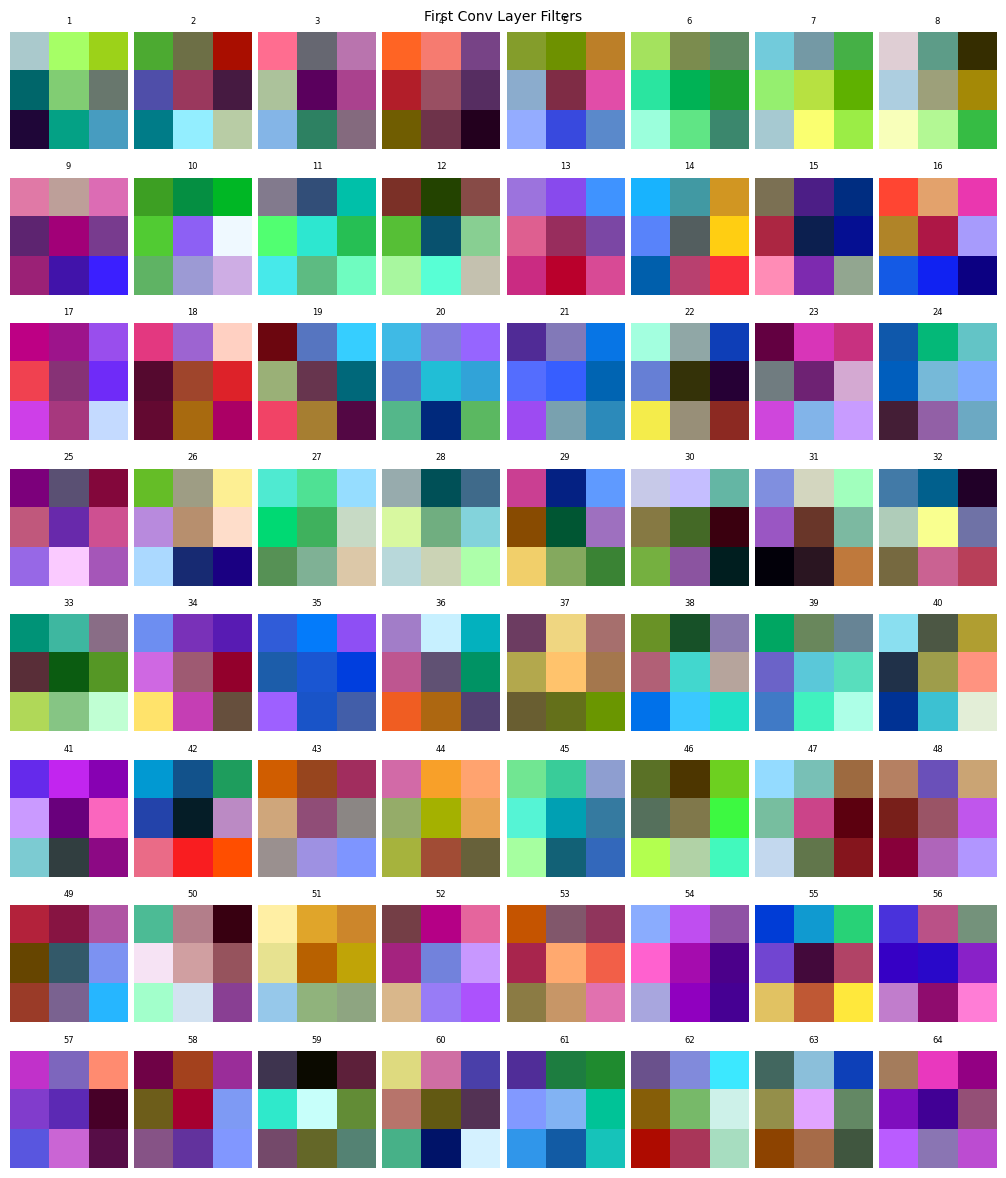

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize the first convolutional layer filters
def visualize_filters(model):
    model.eval()

    # Extract the first convolutional layer (first Conv2D in block1)
    first_conv_layer = model.block1[0]

    if isinstance(first_conv_layer, nn.Conv2d):
        weights = first_conv_layer.weight.data.cpu().numpy()  # Get filter weights
        num_filters = weights.shape[0]  # Number of filters

        num_columns = 8  # Number of filters per row
        num_rows = int(np.ceil(num_filters / num_columns))  # Number of rows

        fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 1.5))  # Smaller size
        axes = axes.flatten()

        for i in range(min(num_filters, len(axes))):
            filter_img = weights[i]  # Get filter
            filter_img = np.transpose(filter_img, (1, 2, 0))  # Rearrange dimensions

            # Normalize for better visualization
            filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())

            axes[i].imshow(filter_img)
            axes[i].axis('off')
            axes[i].set_title(f"{i+1}", fontsize=6)  # Smaller text

        plt.suptitle("First Conv Layer Filters", fontsize=10)
        plt.tight_layout(pad=0.5)
        plt.show()

# Call function to visualize filters
visualize_filters(model)


#Step 11: Visualizing Feature Maps from Convolutional Layers
This step extracts and displays feature maps from the early convolutional layers of the trained CNN model to understand how it processes images.

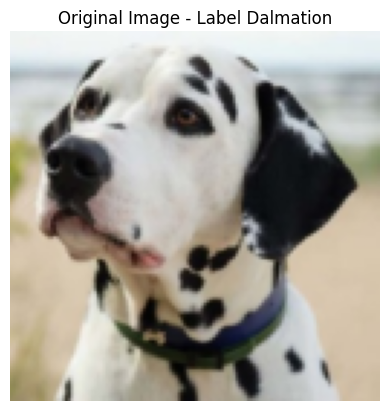

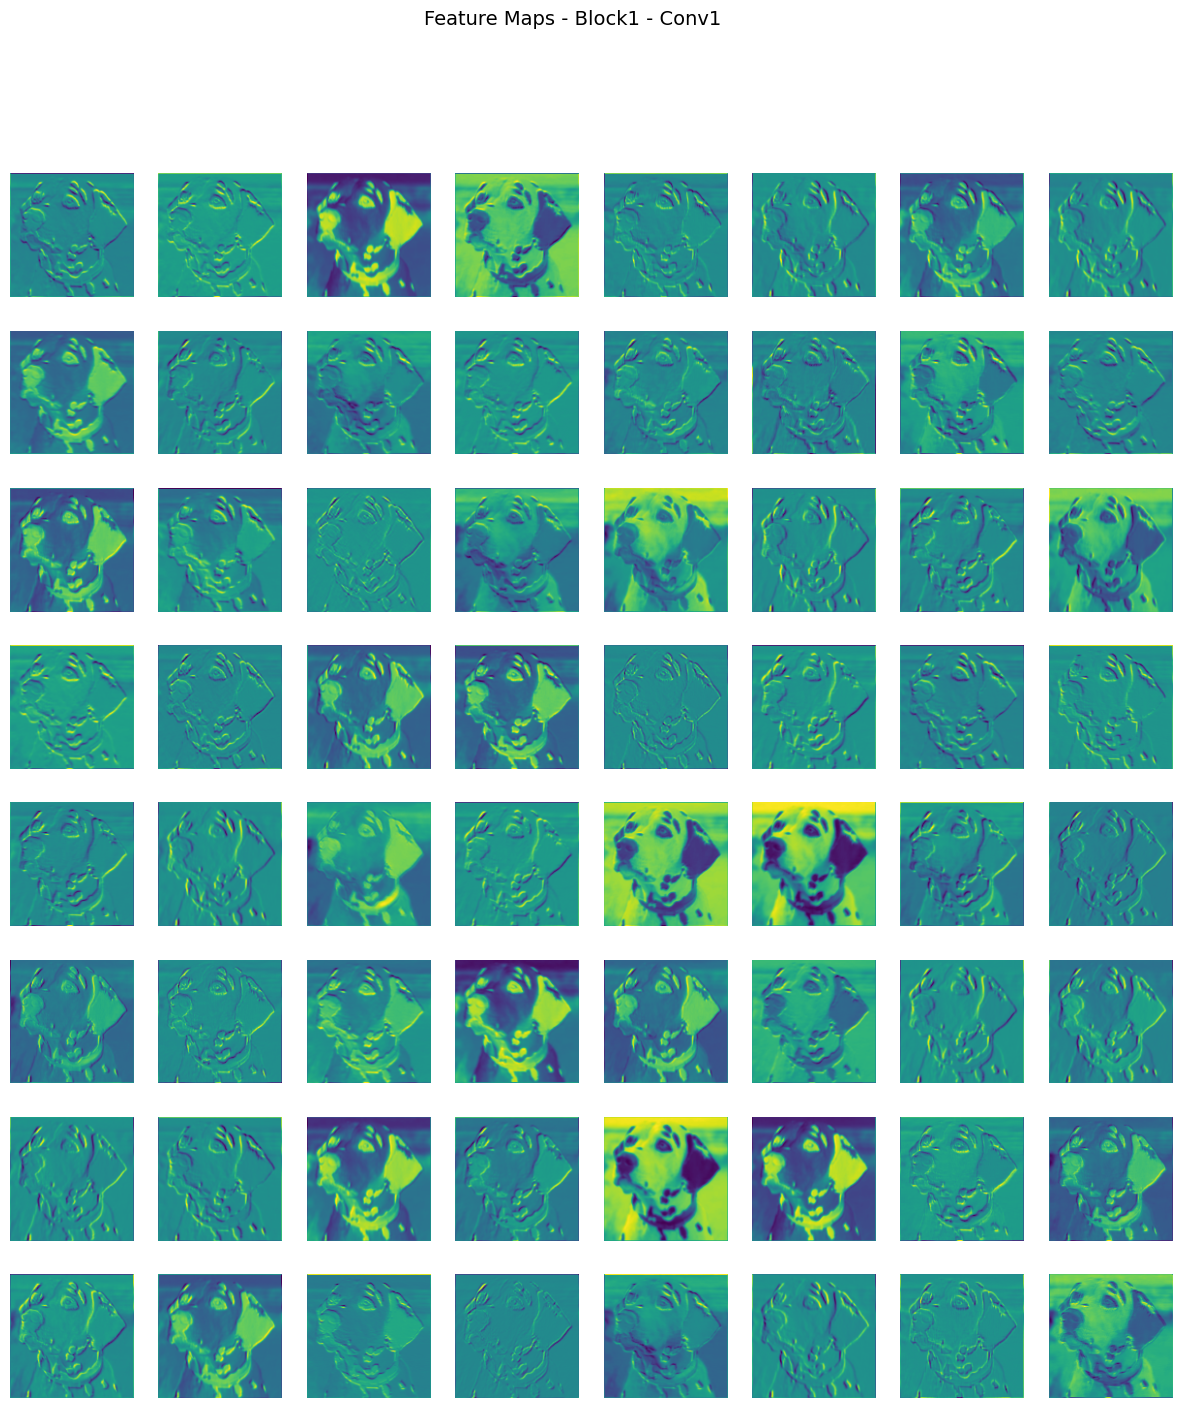

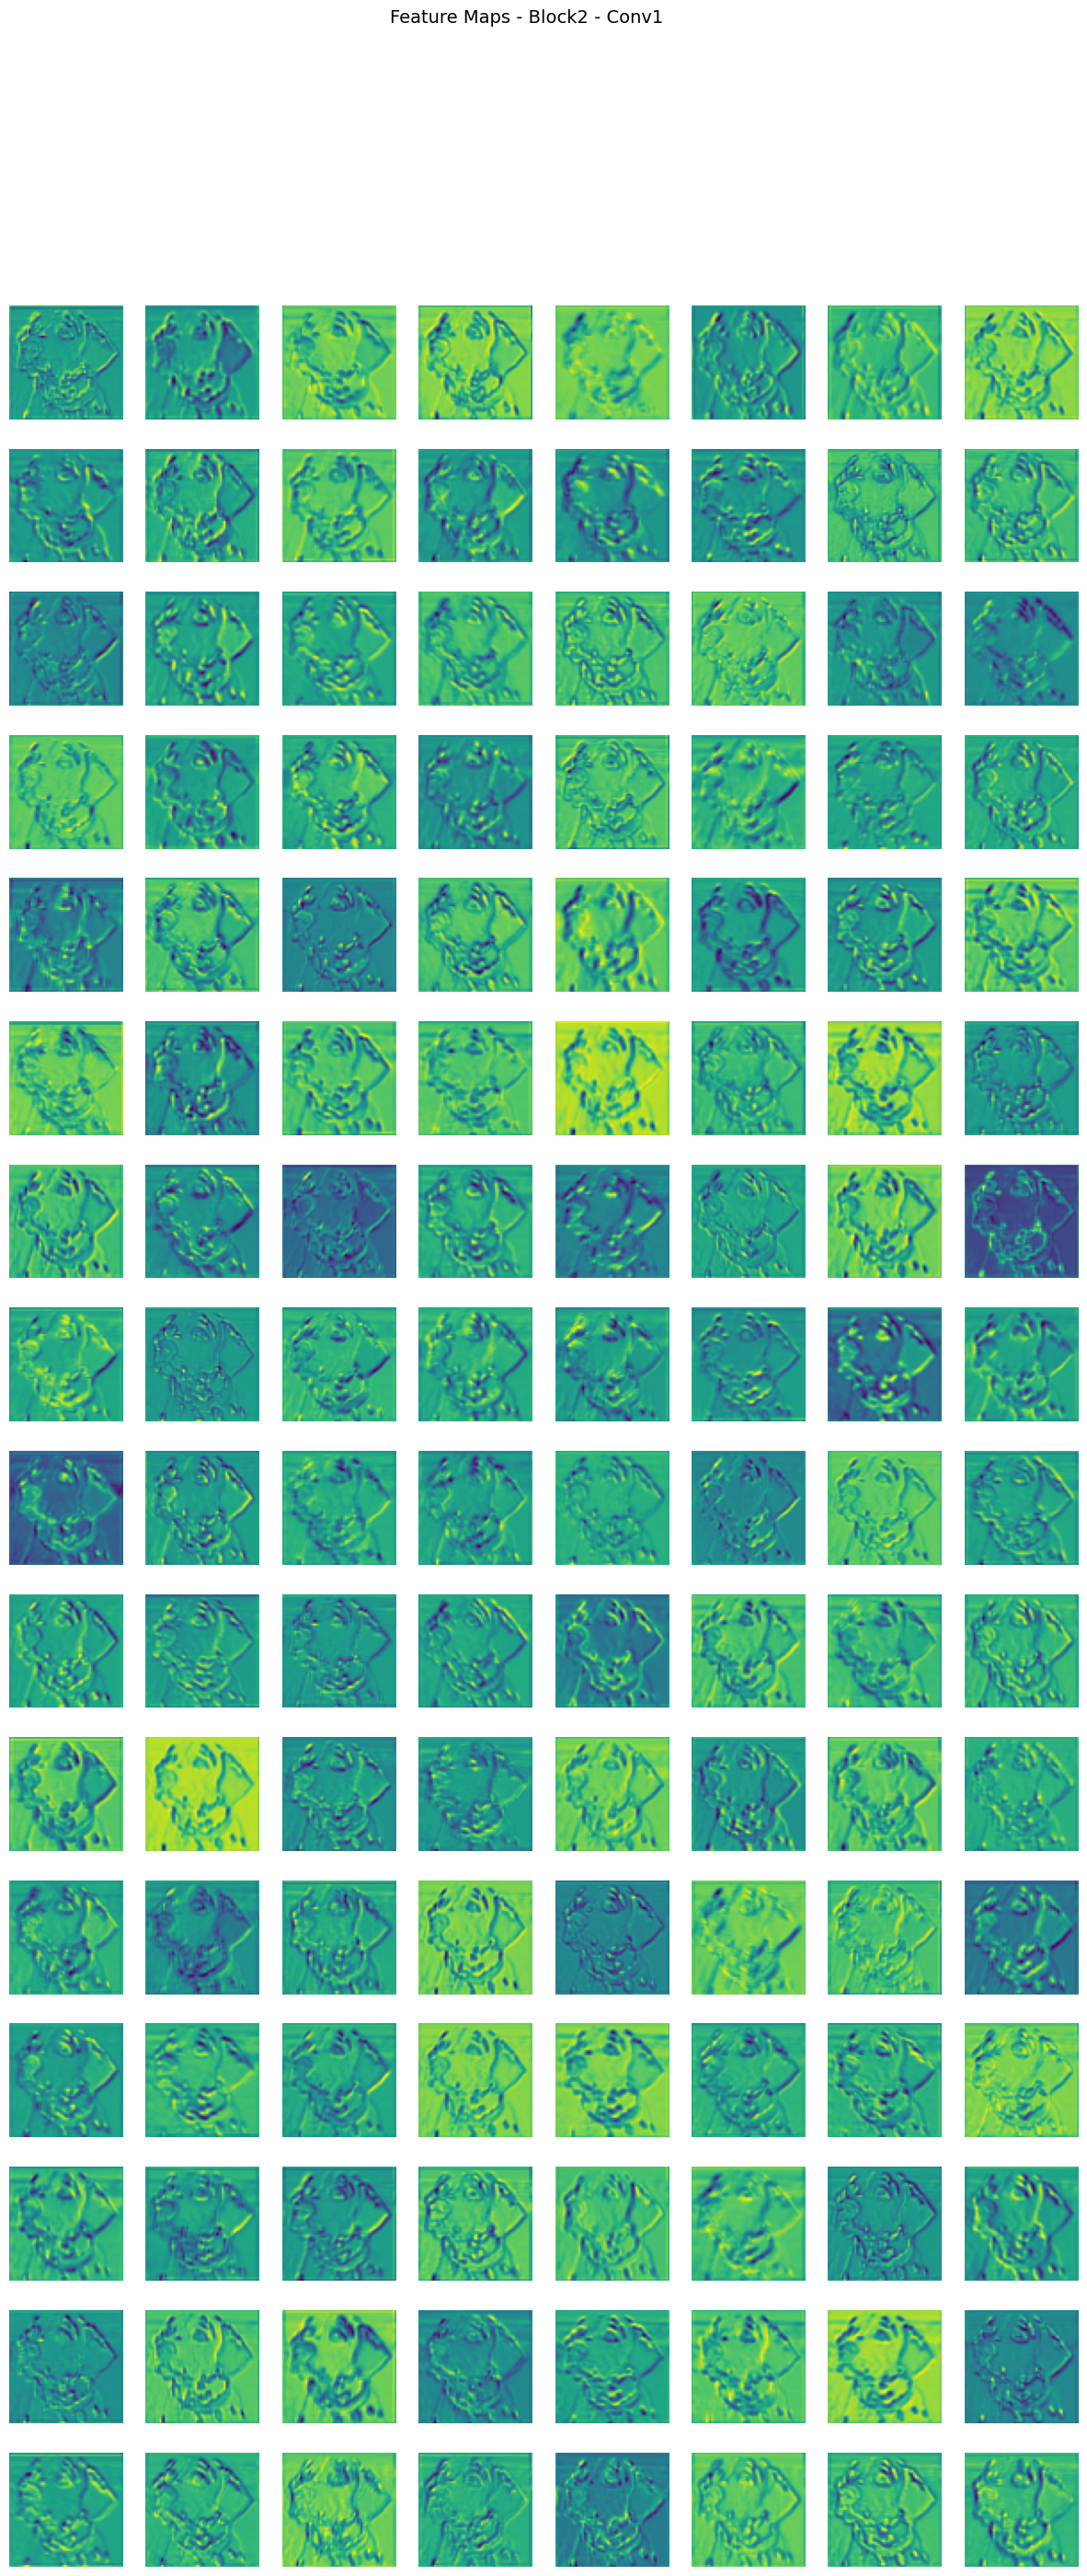

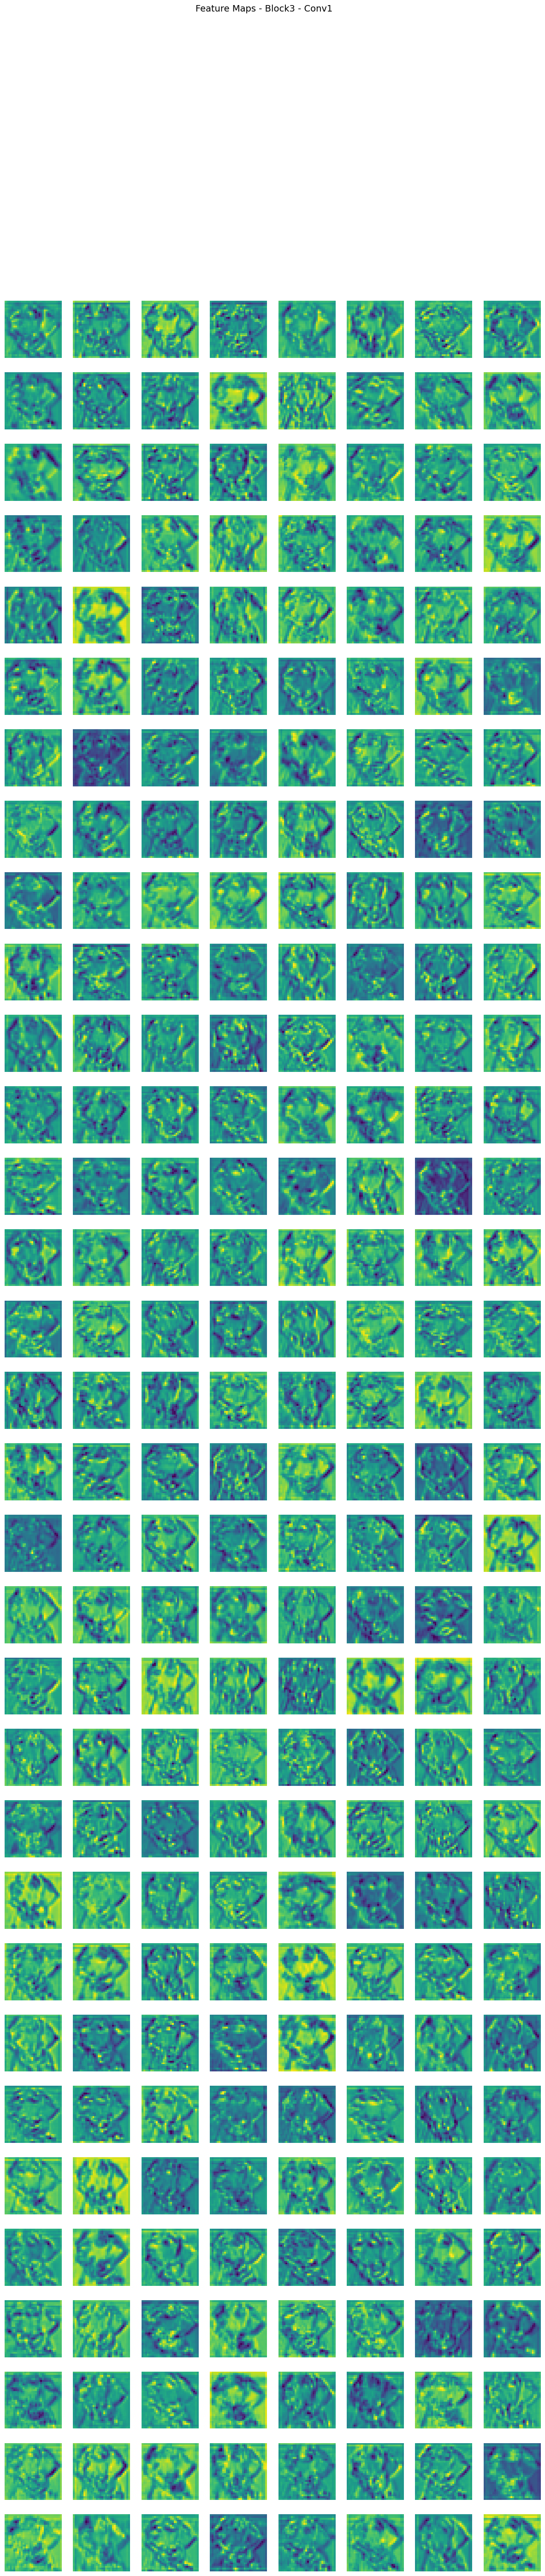

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to get a random image from the dataset
def get_random_image_from_dataset(dataset):
    index = random.randint(0, len(dataset) - 1)  # Select a random index
    image, label = dataset[index]
    return image, label

# Function to extract feature maps from selected layers
def get_feature_maps(model, image_tensor, layers_to_visualize):
    model.eval()
    outputs = []
    hooks = []

    # Hook function to capture outputs of selected layers
    def hook_fn(module, input, output):
        outputs.append(output.cpu().detach())

    # Register hooks to selected layers
    for layer in layers_to_visualize:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass on the image
    with torch.no_grad():
        model(image_tensor.unsqueeze(0).to(device))  # Add batch dimension

    # Remove hooks after execution
    for hook in hooks:
        hook.remove()

    return outputs

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, layer_names, num_columns=8):
    for i, fmap in enumerate(feature_maps):
        fmap = fmap.squeeze(0)  # Remove batch dimension
        num_filters = fmap.shape[0]

        num_rows = int(np.ceil(num_filters / num_columns))  # Compute number of rows
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 2 * num_rows))

        for j, ax in enumerate(axes.flat):
            if j < num_filters:
                ax.imshow(fmap[j], cmap='viridis')
            ax.axis('off')

        plt.suptitle(f"Feature Maps - {layer_names[i]}", fontsize=14)
        plt.show()

# Select a random image from the test set
sample_image, sample_label = get_random_image_from_dataset(test_data)

# Display the original image
plt.imshow(sample_image.permute(1, 2, 0) * 0.5 + 0.5)  # Denormalization to restore colors
plt.title(f"Original Image - Label {test_data.classes[sample_label]}")
plt.axis('off')
plt.show()

# Select convolutional layers to visualize
layers_to_visualize = [model.block1[0],  # First conv layer
                       model.block2[0],  # First conv layer of block2
                       model.block3[0]]  # First conv layer of block3

layer_names = ["Block1 - Conv1", "Block2 - Conv1", "Block3 - Conv1"]

# Extract and visualize feature maps
feature_maps = get_feature_maps(model, sample_image, layers_to_visualize)
visualize_feature_maps(feature_maps, layer_names)
